In [9]:
## Imports
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [10]:
## Constants
COLORS = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf',
          '#1a55FF']
CAT = {
    'usr': 'total-cpu-usage',
    'sys': 'total-cpu-usage',
    'idl': 'total-cpu-usage',
    'wai': 'total-cpu-usage',
    'hiq': 'total-cpu-usage',
    'siq': 'total-cpu-usage',

    'used' : 'memory usage',
    'buff' : 'memory usage',
    'cache' : 'memory usage',
    'free' : 'memory usage',

    'files': 'filesystem',
    'inodes' : 'fileystem',

    'read' : 'dsk/total',
    'writ' : 'dsk/total',
    'reads' : 'dsk/total',
    'writs' : 'dsk/total',

    'recv' : 'net/eth0',
    'send' : 'net/eth0',

    'lis' : 'tcp sockets',
    'act' : 'tcp sockets',
    'syn' : 'tcp sockets',
    'tim' : 'tcp sockets',
    'clo' : 'tcp sockets',

    'int' : 'system',
    'csw' : 'system',

    'run' : 'procs',
    'blk' : 'procs',
    'new' : 'procs'
}

CAT_NAMES = ['total-cpu-usage', 'memory-usage', 'filesystem', 'dsk-total1', 'dsk-total2', 'net-eth0', 'tcp sockets', 'system', 'procs',]

COL_NAMES = [
    # total-cpu-usage
    'usr: CPU usage by user processes [%]', 
    'sys: CPU usage by system processes [%]',
    'idl: Number of idle processes [#]',
    'wai: Number of waiting processes [#]',
    'hiq: Number of hard interrupts [#]',
    'siq: Number of soft interrupts [#]',
    # memory usage
    # https://www.tecmint.com/dstat-monitor-linux-server-performance-process-memory-network/
    # https://linuxtect.com/linux-dstat-command-monitor-linux-performance-and-resource-usage/
    # https://www.thegeekdiary.com/understanding-proc-meminfo-file-analyzing-memory-utilization-in-linux/
    # /proc/meminfo
    'used: Amount of used memory [Bytes]', # / 1024 = KB
    'buff: Amount of buffered memory [Bytes]', # / 1024 / 1024 = MB
    'cache: Amount of cached memory [Bytes]',
    'free: Amount of free memory [Bytes]',

    # filesystem
    # https://www.linuxquestions.org/questions/linux-general-1/proc-sys-fs-file-nr-57646/
    # /proc/sys/fs/file-nr
    'files: Number of allocated file handles [#]',
    'inodes: Number of used file handles [#]',

    # dsk/total
    'read: Amount of read bytes on disk [Bytes]', # not 100% sure
    'writ: Amount of written bytes on disk [Bytes]', # / 1024 = KB

    # dsk/total
    'reads: Number of read operations on disk [#]',
    'writs: Number of write operations on disk [#]',
    
    # net/eth0
    'recv: Amount of received bytes on eth0 [B]', # /1024 = k
    'send: Amount of received bytes on eth0 [B]',

    # tcp sockets
    # http://karunsubramanian.com/network/what-is-syn_sent-socket-status/
    # /proc/net/tcp
    # /proc/net/tcp6
    'lis: Number of TCP connections with status "listening" [#]', 
    'act: Number of TCP connections with status "established" (active) [#]',
    'syn: Number of TCP connections with status "syn_sent", "syn_receive" or "last_ack" [#]',
    'tim: Number of TCP connections with status "waiting"[#]',
    'clo: Number of TCP connections with status "fin-wait1/2", "close/_wait" or "closign" (closed) [#]',

    # system
    # https://www.tecmint.com/dstat-monitor-linux-server-performance-process-memory-network/
    'int: Number of interrupts [#]', 
    'csw: Number of ontext switches [#]', 

    # procs
    # /proc/stat
    'run: Number of processes with status "running" [#]', 
    'blk: Number of processes with status "blocked" [#]',
    'new: Number of processes with status "new" [#]' 
]
PERIOD = 60
WINDOWS = [1, 5, 6, 10, 20, 30, 60, 120]
WINDOWS = [60, 120]

## Create dataframes

In [11]:
import processCSV

# load dataset and names
dfs, names = processCSV.processCSV()

# sanity check
for (df, name) in zip(dfs, names):
     print (df['usr'].iloc[0], name)

05csv-infected(httpbackdoor)
01csv-healthy
04csv-healthy
02csv-infected(BASHLITE)
03csv-infected(Ransomware)
4.395 05csv-infected(httpbackdoor)
6.391 01csv-healthy
5.698 04csv-healthy
5.698 02csv-infected(BASHLITE)
5.627 03csv-infected(Ransomware)


4.395 05csv-infected(httpbackdoor)
6.391 01csv-healthy
usr-mean
1


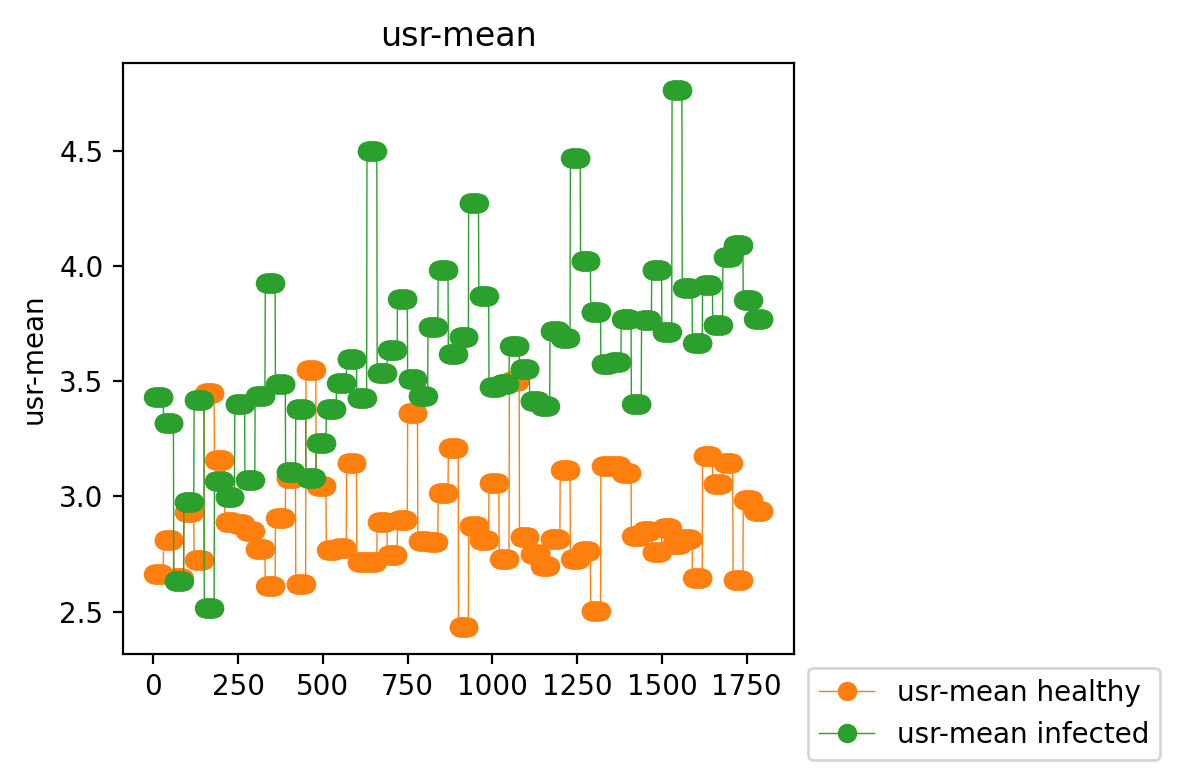

usr-mean
1


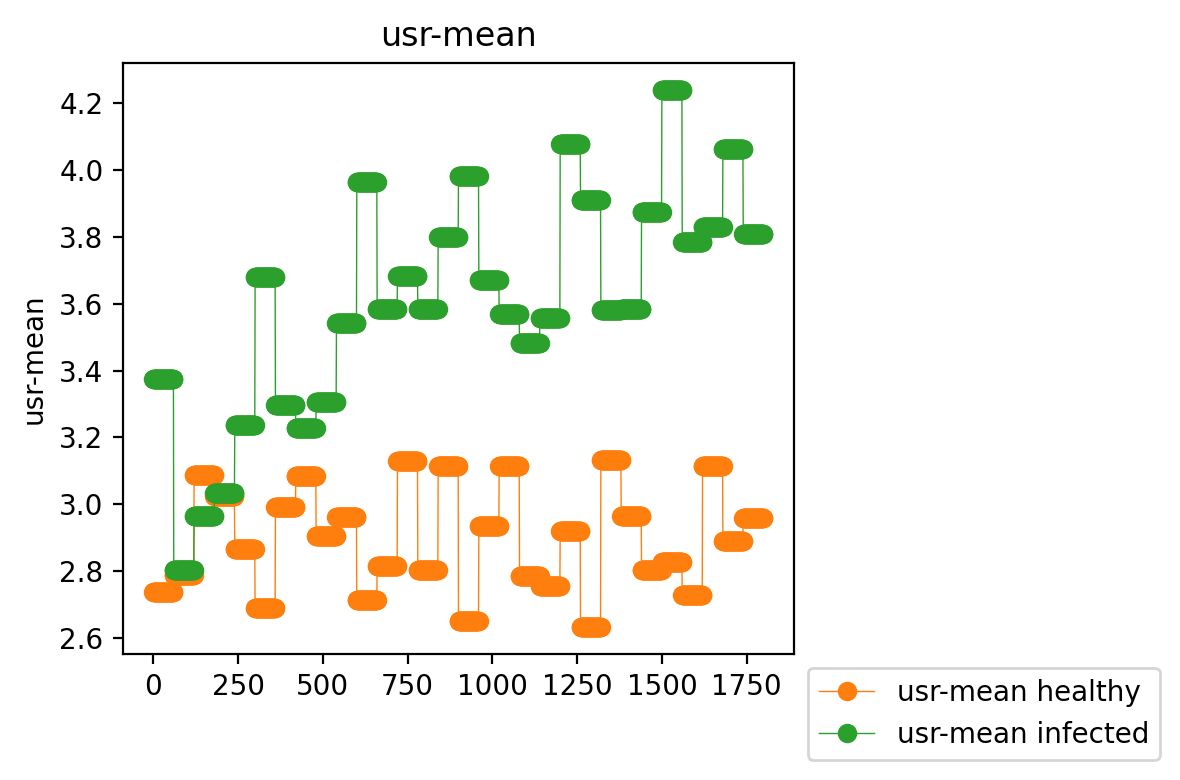

usr-mean
1


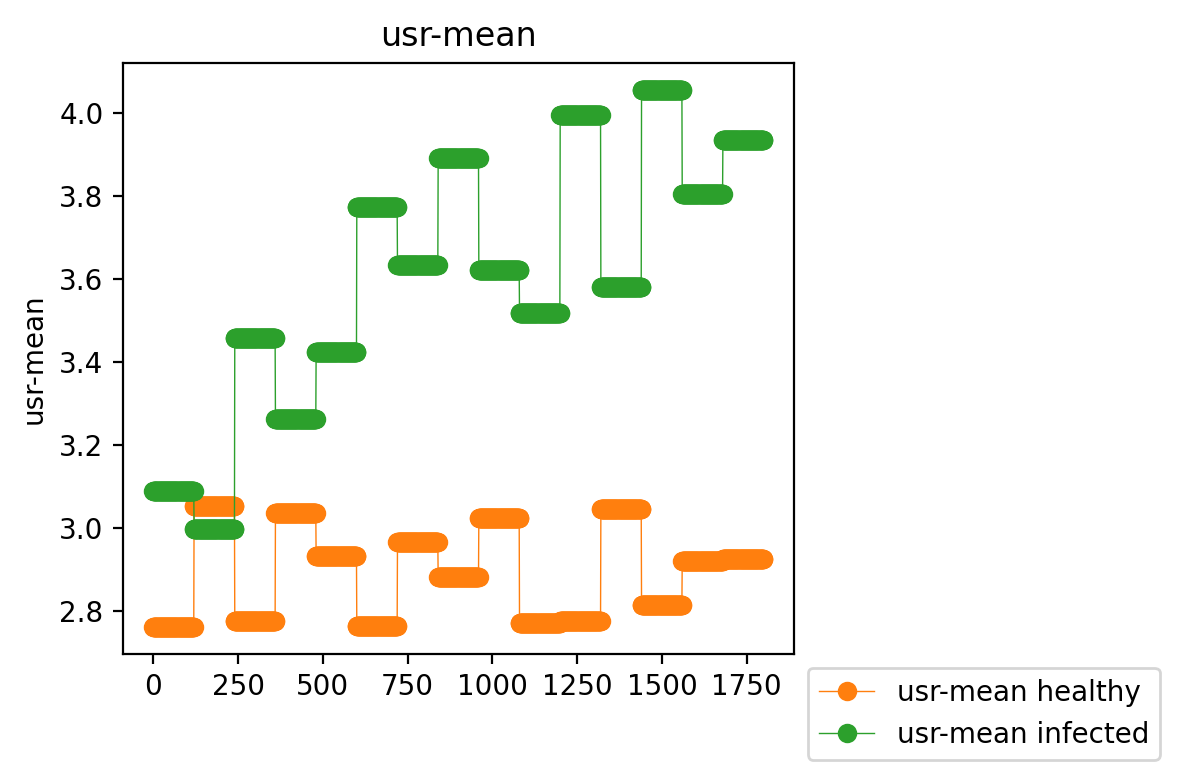

sys-mean
1


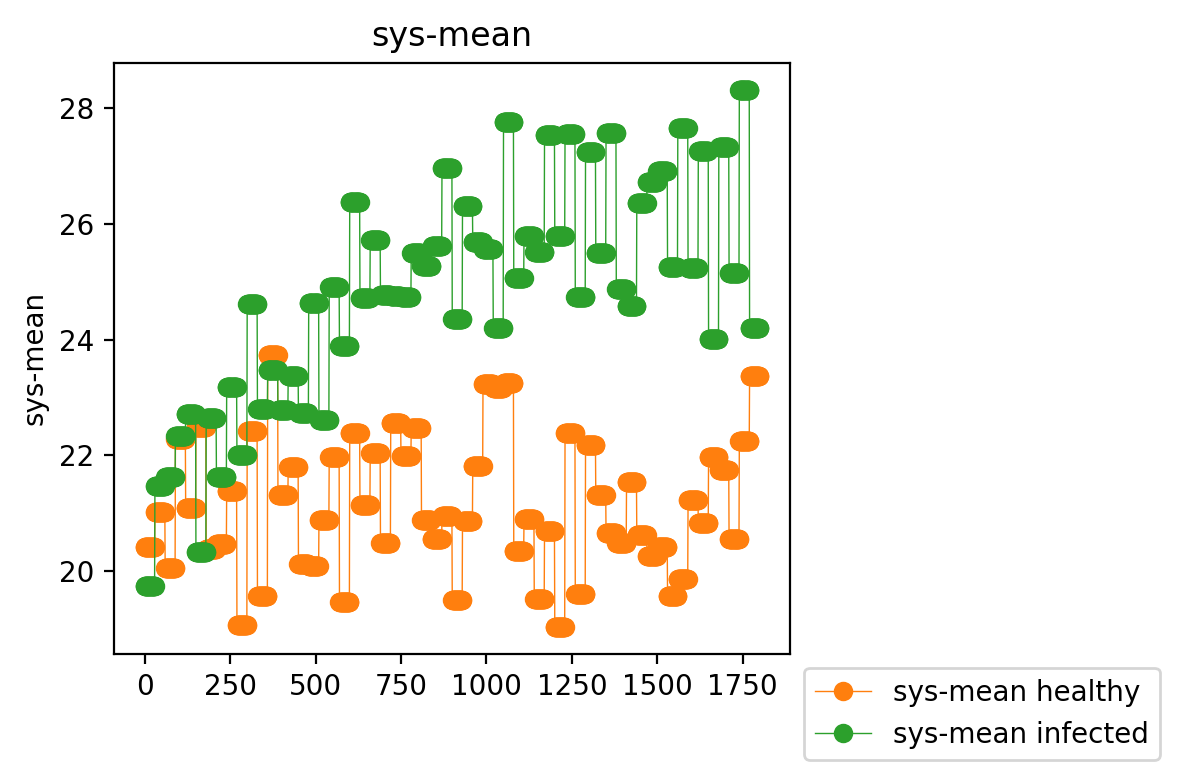

sys-mean
1


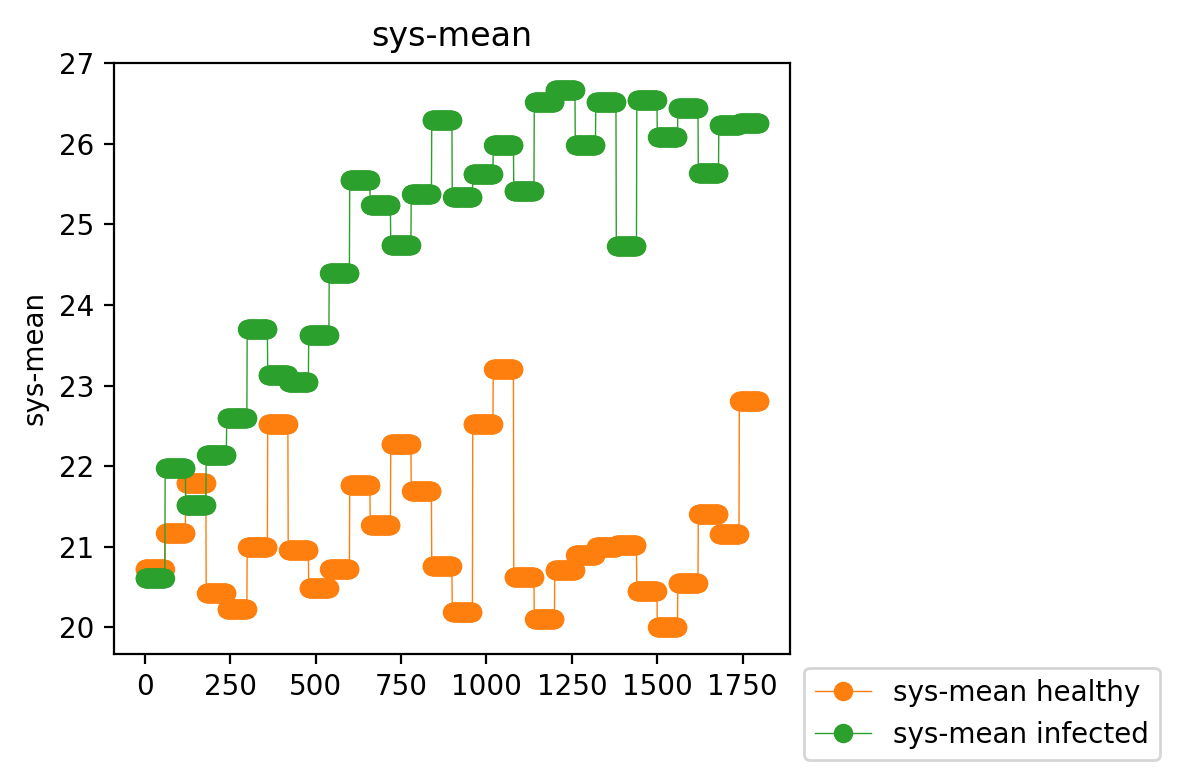

sys-mean
1


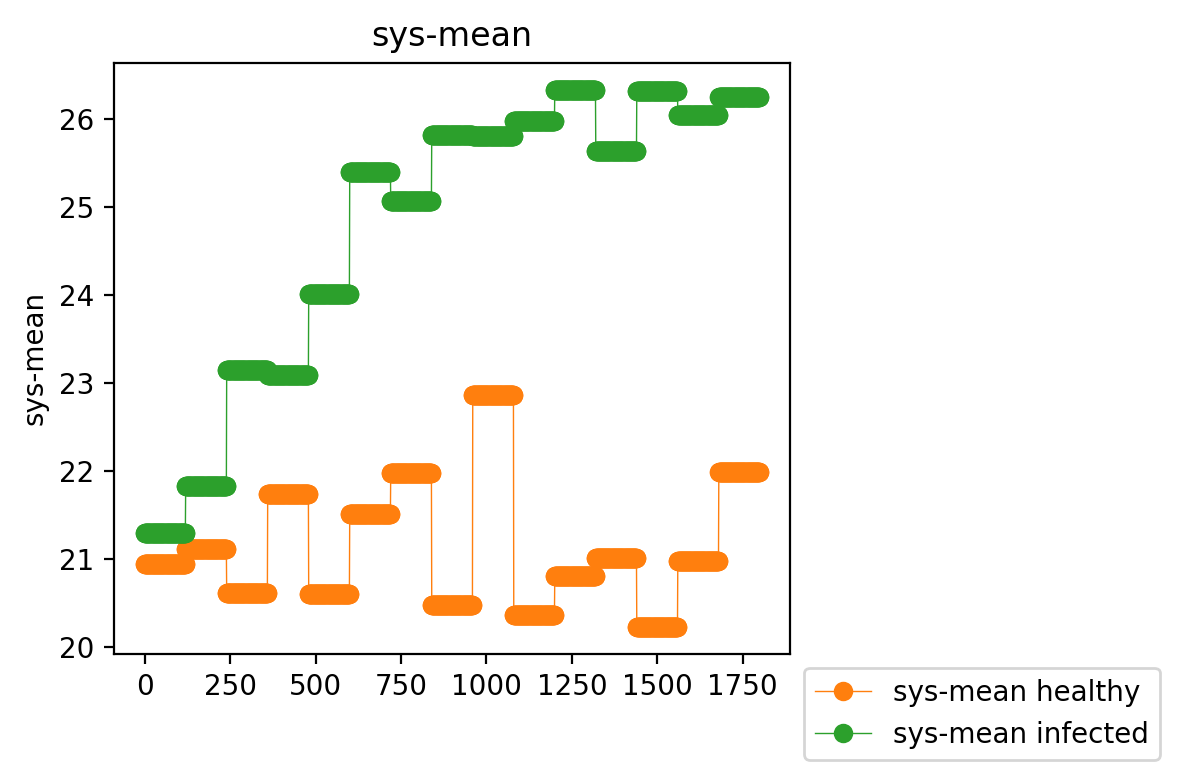

idl-mean
1


KeyboardInterrupt: 

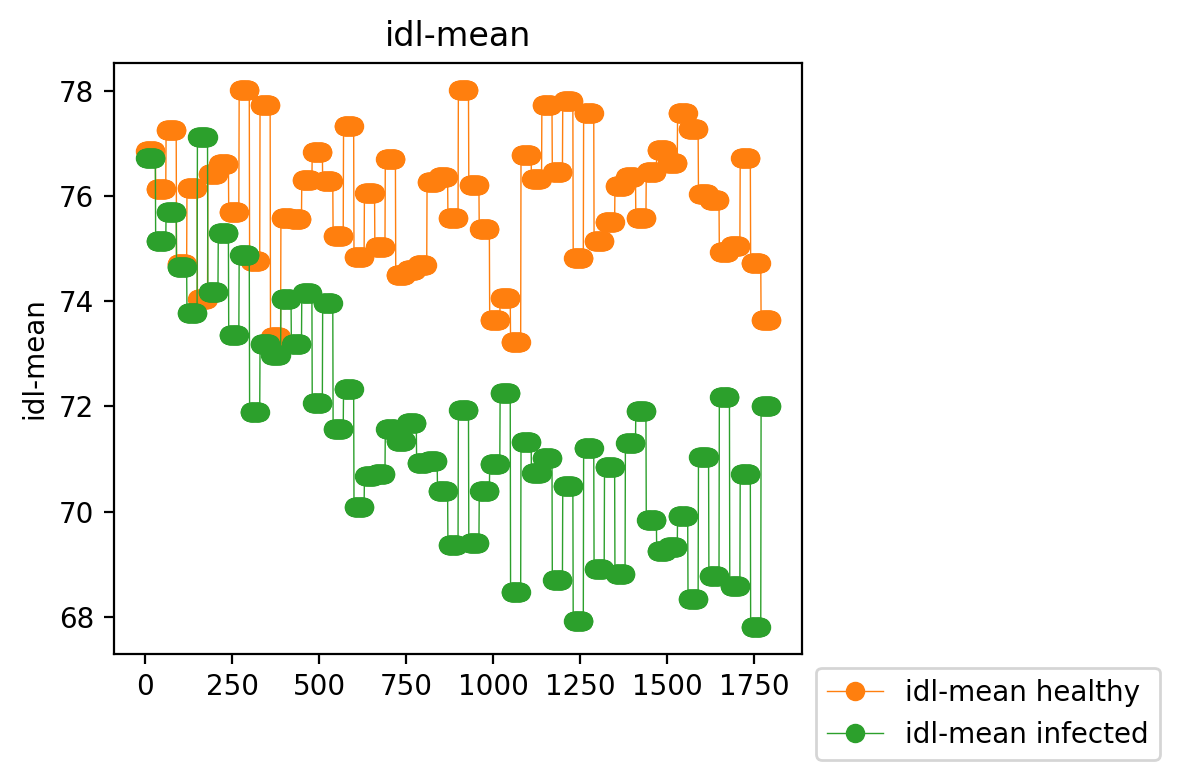

In [12]:
WINDOWS = [30, 60, 120]
INFECTED = [0, 3, 4] # positions of the infected datasets
HEALTHY = [1] # position of the healthy dataset

# reset index (can't plot a time series)
dfs[HEALTHY[0]].reset_index(inplace=True)

# export col names for labeling
cols = dfs[HEALTHY[0]].columns.values.tolist()
cols = cols[1:] # remove time col

for infIndex in INFECTED:
    # debug only
    # print(dfs[infIndex]['usr'].iloc[0],names[infIndex])
    # print(dfs[HEALTHY[0]]['usr'].iloc[0],names[HEALTHY[0]])

    # reset index
    dfs[infIndex].reset_index(inplace=True)
    for i in cols:

        str = i + '-mean'
        for window in WINDOWS:
            print(str)
            print(HEALTHY[0])
            dfs[HEALTHY[0]][str]  = dfs[HEALTHY[0]][i].rolling(window).mean()[window-1::window]
            dfs[HEALTHY[0]][str].bfill(inplace = True)
            dfs[infIndex][str]  = dfs[infIndex][i].rolling(window).mean()[window-1::window]
            dfs[infIndex][str].bfill(inplace = True)
            
            
            plt.figure(dpi=200)
            plt.title(label=str)
            dfs[HEALTHY[0]][str].plot(marker="o", color=COLORS[1], linestyle='-', linewidth=0.5, label= str + " healthy")
            dfs[infIndex][str].plot(marker="o", color=COLORS[2], linestyle='-', linewidth=0.5, label= str + " infected")
            #plt.xlabel('Timestamp [hh:mm:ss] from {}'.format(startDate))
            plt.ylabel(str)
            plt.legend(loc='upper left', bbox_to_anchor=(1, 0))
            plt.tight_layout()
            plt.title(str)
            plt.savefig('plots/'+str+'{}'.format(window), facecolor='white', transparent=False)   
            plt.show()

